In [1]:
import pandas as pd
import xlrd
import plotly.express as px
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_excel('CompetitionData.xlsx')
df

Date  Temperature     Load  Prediction
0     2008-01-01 01:00:00        25.00  10737.0         NaN
1     2008-01-01 02:00:00        24.00  10348.0         NaN
2     2008-01-01 03:00:00        23.00   9997.0         NaN
3     2008-01-01 04:00:00        23.00   9760.0         NaN
4     2008-01-01 05:00:00        23.00   9624.0         NaN
...                   ...          ...      ...         ...
43843 2012-12-31 20:00:00        22.33      NaN         NaN
43844 2012-12-31 21:00:00        20.67      NaN         NaN
43845 2012-12-31 22:00:00        19.67      NaN         NaN
43846 2012-12-31 23:00:00        19.33      NaN         NaN
43847 2013-01-01 00:00:00        18.33      NaN         NaN

[43848 rows x 4 columns]

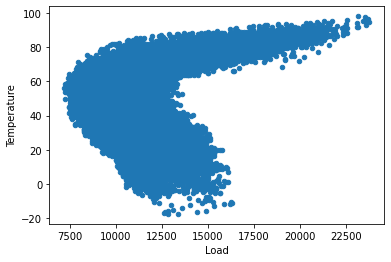

In [3]:
df.plot.scatter(x='Load', y='Temperature');

In [4]:
df['Temperature_2'] = np.power(df['Temperature'], 2);

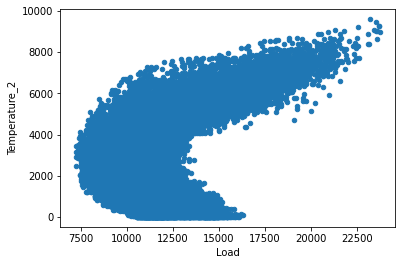

In [5]:
df.plot.scatter(x='Load', y='Temperature_2');

In [81]:
fig = px.line(df,x='Date',y='Load')
fig.update_xaxes(rangeslider_visible=True)
fig.show();

In [7]:
df['hour'] = df['Date'].dt.hour
df['dayofweek'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear
df.head()

<ipython-input-7-7df90240042c>:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



Date  Temperature     Load  Prediction  Temperature_2  hour  \
0 2008-01-01 01:00:00         25.0  10737.0         NaN          625.0     1   
1 2008-01-01 02:00:00         24.0  10348.0         NaN          576.0     2   
2 2008-01-01 03:00:00         23.0   9997.0         NaN          529.0     3   
3 2008-01-01 04:00:00         23.0   9760.0         NaN          529.0     4   
4 2008-01-01 05:00:00         23.0   9624.0         NaN          529.0     5   

   dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear  
0          1        1      1  2008          1           1           1  
1          1        1      1  2008          1           1           1  
2          1        1      1  2008          1           1           1  
3          1        1      1  2008          1           1           1  
4          1        1      1  2008          1           1           1

In [8]:
df['Load_diff1'] = df['Load'].diff(1)
df['Temp_diff1'] = df['Temperature'].diff(1)
df.head()

Date  Temperature     Load  Prediction  Temperature_2  hour  \
0 2008-01-01 01:00:00         25.0  10737.0         NaN          625.0     1   
1 2008-01-01 02:00:00         24.0  10348.0         NaN          576.0     2   
2 2008-01-01 03:00:00         23.0   9997.0         NaN          529.0     3   
3 2008-01-01 04:00:00         23.0   9760.0         NaN          529.0     4   
4 2008-01-01 05:00:00         23.0   9624.0         NaN          529.0     5   

   dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear  \
0          1        1      1  2008          1           1           1   
1          1        1      1  2008          1           1           1   
2          1        1      1  2008          1           1           1   
3          1        1      1  2008          1           1           1   
4          1        1      1  2008          1           1           1   

   Load_diff1  Temp_diff1  
0         NaN         NaN  
1      -389.0        -1.0  
2      -351.0        -1.0  
3      -237.0         0.0  
4      -136.0         0.0

In [83]:
fig = px.line(df,x='Date',y='Load_diff1')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [10]:
df.dtypes

Date             datetime64[ns]
Temperature             float64
Load                    float64
Prediction              float64
Temperature_2           float64
hour                      int64
dayofweek                 int64
quarter                   int64
month                     int64
year                      int64
dayofyear                 int64
dayofmonth                int64
weekofyear                int64
Load_diff1              float64
Temp_diff1              float64
dtype: object

In [11]:
X_train = df.loc[df['Date']<'01-01-2011'][['Temperature', 
                                           'hour', 'dayofweek', 'quarter', 'month', 'year',
                                           'dayofyear', 'dayofmonth', 'weekofyear']]

X_test = df.loc[(df['Date']>'01-01-2011')&(df['Date']<'01-01-2012')][['Temperature',
                                                                      'hour', 'dayofweek', 'quarter', 'month', 'year',
                                                                      'dayofyear', 'dayofmonth', 'weekofyear']]

In [12]:
y_train = df.loc[df['Date']<'01-01-2011']['Load']

y_test = df.loc[(df['Date']>'01-01-2011')&(df['Date']<'01-01-2012')]['Load']

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, verbose=False)

C:\Users\Rizabek\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

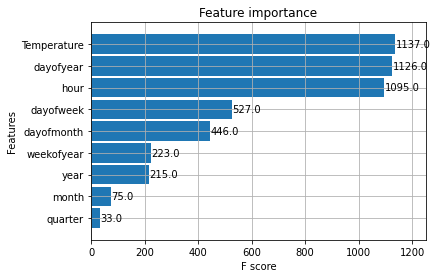

In [14]:
_ = plot_importance(reg, height=0.9)

In [15]:
df_test = df.loc[(df['Date']>'01-01-2011')&(df['Date']<'01-01-2012')][['Date','year','month','dayofmonth','Load']].copy()
df_test['Prediction'] = reg.predict(X_test)

<AxesSubplot:>

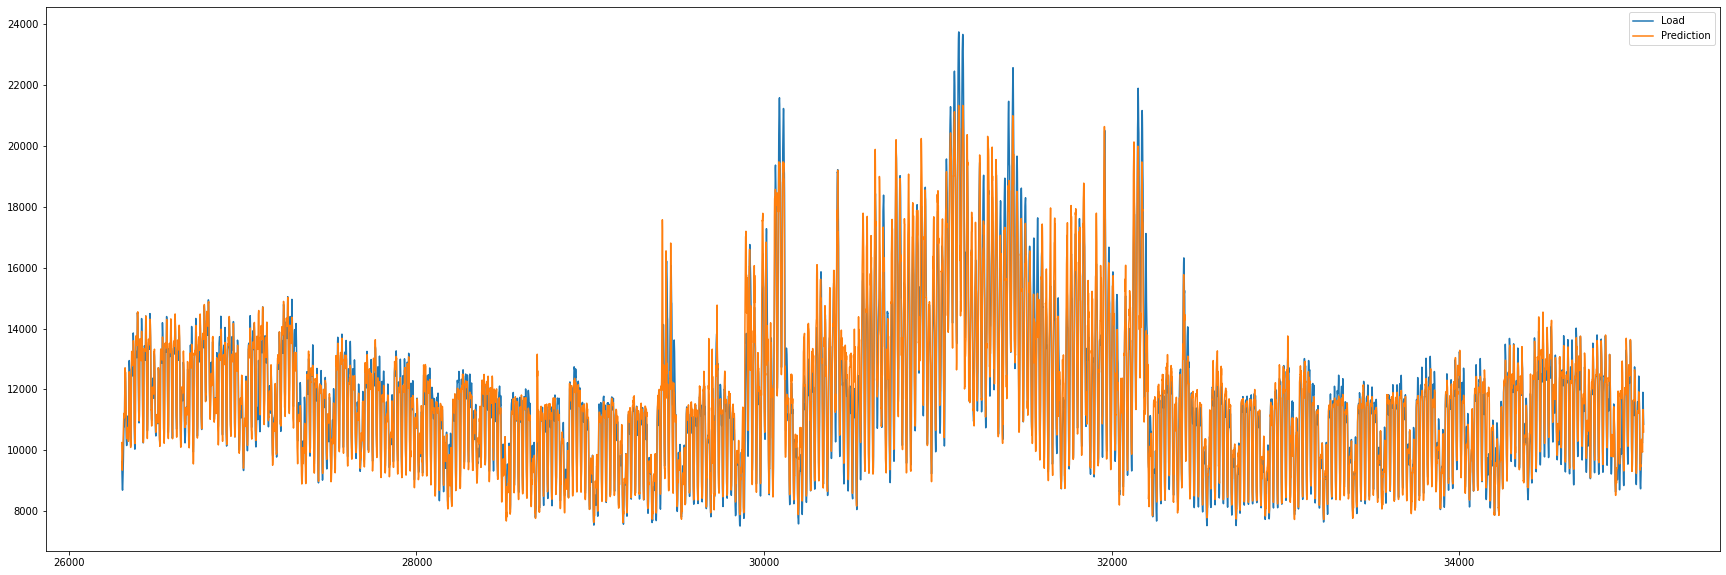

In [16]:
df_test[['Load', 'Prediction']].plot(figsize = (30,10))

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mean_absolute_percentage_error(y_true=df_test['Load'], y_pred=df_test['Prediction'])

3.6693668560576267

In [19]:
df_test['error'] = df_test['Load'] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']).mean()[['Load','Prediction','error','abs_error']]

In [62]:
error_by_day.sort_values('error', ascending=True).head(10).round(0)

Load  Prediction   error  abs_error
year month dayofmonth                                        
2011 5     30          10550.0     12587.0 -2037.0     2088.0
     11    24           9312.0     10881.0 -1570.0     1570.0
     2     2           11285.0     12783.0 -1498.0     1498.0
     7     4           12244.0     13681.0 -1437.0     1437.0
     9     5            8942.0     10314.0 -1372.0     1553.0
     12    26          10091.0     11400.0 -1309.0     1309.0
     6     25          10488.0     11762.0 -1274.0     1274.0
           26          10407.0     11576.0 -1168.0     1180.0
           27          12685.0     13841.0 -1156.0     1156.0
           16          11745.0     12641.0  -896.0      896.0

In [80]:
hol = df.loc[(df['month']==7)&(df['dayofmonth']==4)][['Date','Load']]
hol = hol.set_index('Date')
hol

Load
Date                        
2008-07-04 00:00:00  11425.0
2008-07-04 01:00:00  10734.0
2008-07-04 02:00:00   9857.0
2008-07-04 03:00:00   9189.0
2008-07-04 04:00:00   8757.0
...                      ...
2012-07-04 19:00:00      NaN
2012-07-04 20:00:00      NaN
2012-07-04 21:00:00      NaN
2012-07-04 22:00:00      NaN
2012-07-04 23:00:00      NaN

[120 rows x 1 columns]

In [21]:
# import holidays date
holidays = pd.read_csv('US Holiday Dates.csv')
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays_list = list(holidays['Date'])

In [22]:
df['Holiday'] = df['Date'].apply(lambda x: 1 if x in holidays_list else 0)

In [23]:
X_train2 = df.loc[df['Date']<'01-01-2011'][['Temperature','Holiday',
                                           'hour', 'dayofweek', 'quarter', 'month', 'year',
                                           'dayofyear', 'dayofmonth', 'weekofyear']]

X_test2 = df.loc[(df['Date']>'01-01-2011')&(df['Date']<'01-01-2012')][['Temperature', 'Holiday',
                                                                      'hour', 'dayofweek', 'quarter', 'month', 'year',
                                                                      'dayofyear', 'dayofmonth', 'weekofyear']]

In [65]:
X_train2.loc[X_train2['Holiday']==1].head()

Temperature  Holiday  hour  dayofweek  quarter  month  year  dayofyear  \
479          5.00        1     0          0        1      1  2008         21   
1055        13.67        1     0          3        1      2  2008         45   
1151        32.33        1     0          0        1      2  2008         49   
1966        30.33        1     0          6        1      3  2008         83   
2806        48.00        1     0          6        2      4  2008        118   

      dayofmonth  weekofyear  
479           21           4  
1055          14           7  
1151          18           8  
1966          23          12  
2806          27          17

In [24]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train2, y_train,
        eval_set=[(X_train2, y_train), (X_test2, y_test)],
        early_stopping_rounds=50, verbose=False)

C:\Users\Rizabek\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

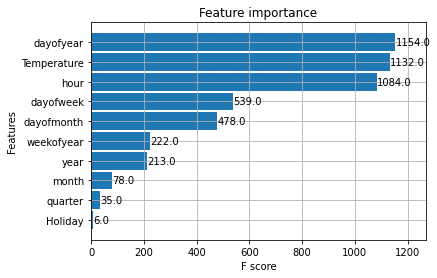

In [25]:
_ = plot_importance(reg, height=0.9)

In [26]:
df_test['Prediction2'] = reg.predict(X_test2)

<AxesSubplot:>

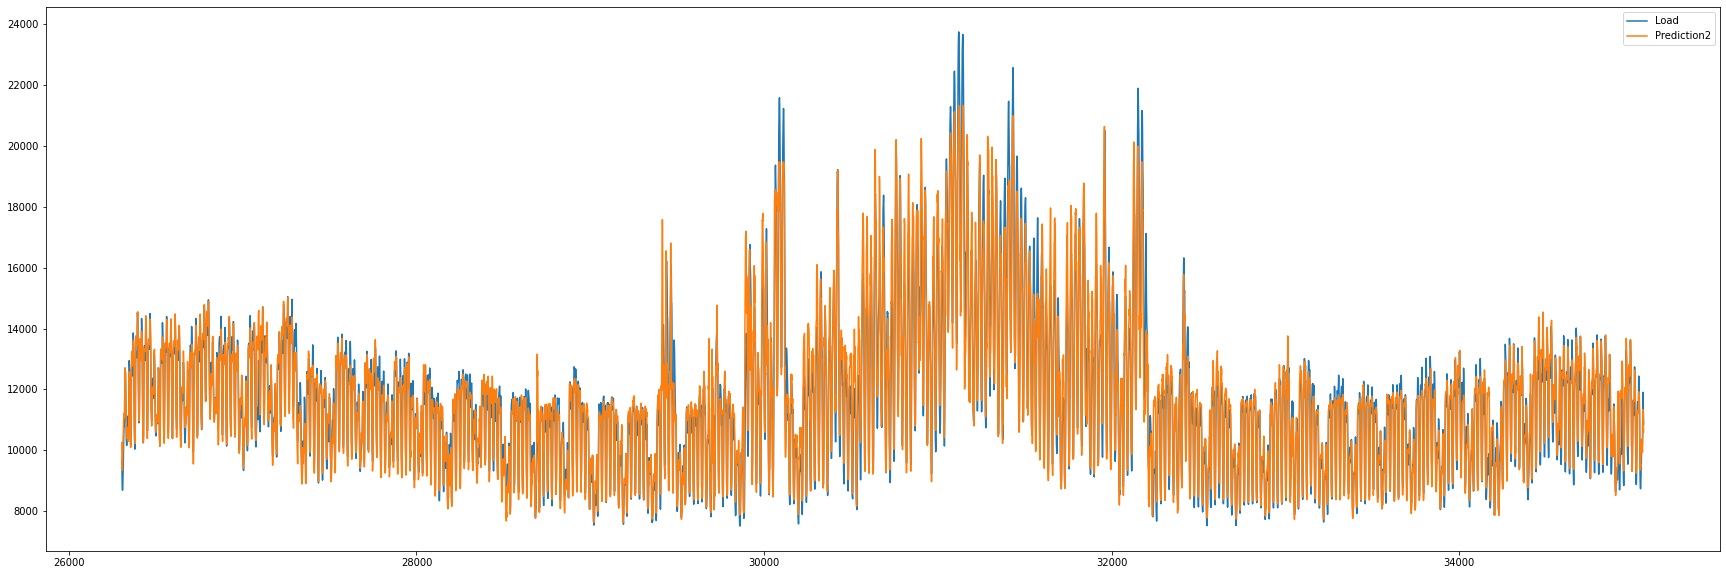

In [27]:
df_test[['Load', 'Prediction2']].plot(figsize = (30,10))

In [28]:
mean_absolute_percentage_error(y_true=df_test['Load'], y_pred=df_test['Prediction2'])

3.6693668560576267

In [29]:
X_train3 = df.loc[df['Date']<'01-01-2012'][['Temperature','hour', 'dayofweek', 'quarter', 'month', 'year',
                                           'dayofyear', 'dayofmonth', 'weekofyear']]

X_test3 = df.loc[(df['Date']>='01-01-2012')][['Temperature','hour', 'dayofweek', 'quarter', 'month', 'year',
                                            'dayofyear', 'dayofmonth', 'weekofyear']]


In [30]:
y_train3 = df.loc[df['Date']<'01-01-2012']['Load']

y_test3 = df.loc[df['Date']>='01-01-2012']['Load']

In [31]:
reg.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [32]:
reg.fit(X_train3, y_train3)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [33]:
X_train3['Prediction'] = reg.predict(X_train3)
X_test3['Prediction'] = reg.predict(X_test3)

In [34]:
df_final = pd.concat([X_train3, X_test3], sort=False)

In [35]:
df_final.to_excel('df_final.xlsx')

In [44]:
df

Date  Temperature     Load    Prediction  Temperature_2  \
0     2008-01-01 01:00:00        25.00  10737.0  10753.500000       625.0000   
1     2008-01-01 02:00:00        24.00  10348.0  10308.168945       576.0000   
2     2008-01-01 03:00:00        23.00   9997.0   9996.649414       529.0000   
3     2008-01-01 04:00:00        23.00   9760.0   9731.960938       529.0000   
4     2008-01-01 05:00:00        23.00   9624.0   9643.926758       529.0000   
...                   ...          ...      ...           ...            ...   
43843 2012-12-31 20:00:00        22.33      NaN  13631.577148       498.6289   
43844 2012-12-31 21:00:00        20.67      NaN  13323.044922       427.2489   
43845 2012-12-31 22:00:00        19.67      NaN  12873.284180       386.9089   
43846 2012-12-31 23:00:00        19.33      NaN  12496.610352       373.6489   
43847 2013-01-01 00:00:00        18.33      NaN  11786.191406       335.9889   

       hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0         1          1        1      1  2008          1           1   
1         2          1        1      1  2008          1           1   
2         3          1        1      1  2008          1           1   
3         4          1        1      1  2008          1           1   
4         5          1        1      1  2008          1           1   
...     ...        ...      ...    ...   ...        ...         ...   
43843    20          0        4     12  2012        366          31   
43844    21          0        4     12  2012        366          31   
43845    22          0        4     12  2012        366          31   
43846    23          0        4     12  2012        366          31   
43847     0          1        1      1  2013          1           1   

       weekofyear  Load_diff1  Temp_diff1  Holiday  
0               1         NaN         NaN        0  
1               1      -389.0       -1.00        0  
2               1      -351.0       -1.00        0  
3               1      -237.0        0.00        0  
4               1      -136.0        0.00        0  
...           ...         ...         ...      ...  
43843           1         NaN       -1.00        0  
43844           1         NaN       -1.66        0  
43845           1         NaN       -1.00        0  
43846           1         NaN       -0.34        0  
43847           1         NaN       -1.00        1  

[43848 rows x 16 columns]

In [41]:
df['Prediction'] = df_final['Prediction']

In [43]:
from plotnine import *

C:\Users\Rizabek\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 8784 rows containing missing values.


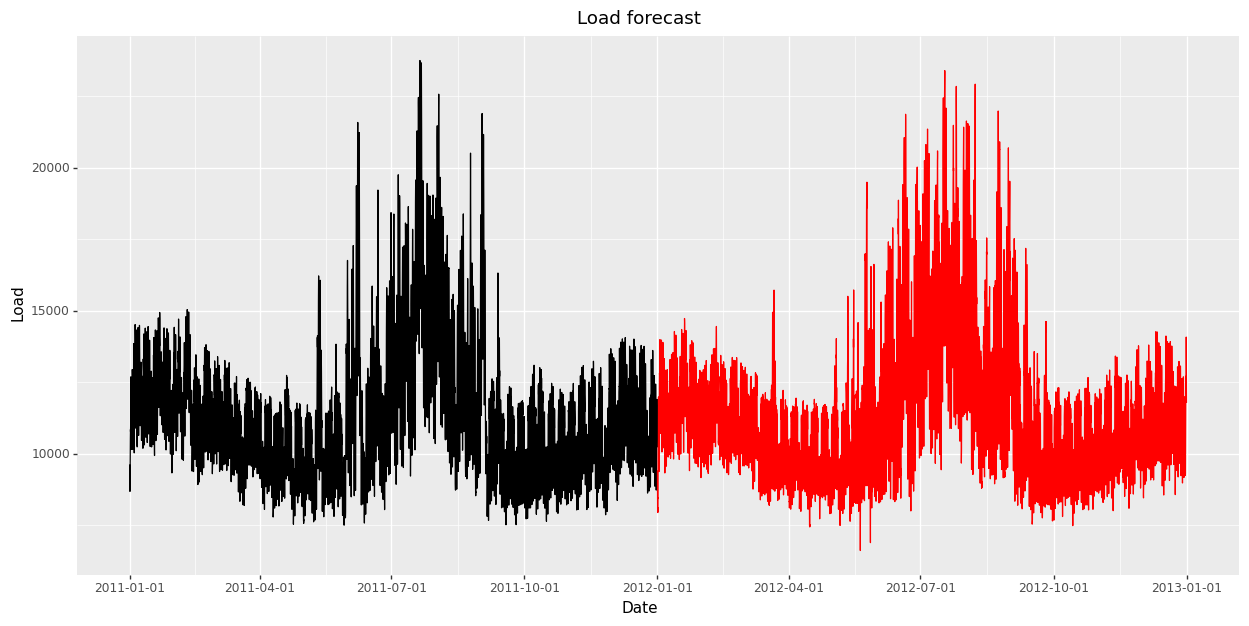

<ggplot: (145707470261)>

In [61]:
(
ggplot(df.loc[df['Date']>'01-01-2011'],aes('Date','Load')) + geom_line()
+ geom_line(df.loc[df['Date']>'01-01-2012'], aes('Date','Prediction'),color='red')
+ theme(figure_size=(15,7))
+ ggtitle("Load forecast") 
)